In [1]:
!pip install fiftyone
!pip install torch torchvision

     |████████████████████████████████| 1.2 MB 7.4 MB/s 
     |████████████████████████████████| 106 kB 41.1 MB/s 
     |████████████████████████████████| 225 kB 46.5 MB/s 
     |████████████████████████████████| 631 kB 53.1 MB/s 
     |████████████████████████████████| 29.2 MB 49 kB/s 
     |████████████████████████████████| 79.9 MB 110 kB/s 
     |████████████████████████████████| 13.2 MB 35.3 MB/s 
     |████████████████████████████████| 47.6 MB 74 kB/s 
     |████████████████████████████████| 557 kB 69.1 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 131 kB 71.7 MB/s 
     |████████████████████████████████| 82 kB 959 kB/s 
     |████████████████████████████████| 58 kB 7.9 MB/s 
     |████████████████████████████████| 54 kB 4.4 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 77 kB 8.5 MB/s 
     |████████████████████████████████| 8.1 MB 36.3 MB/s 
     |██████████████████████

In [2]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 52243, done.
remote: Counting objects: 100% (17713/17713), done.
remote: Compressing objects: 100% (3763/3763), done.
remote: Total 52243 (delta 14599), reused 16543 (delta 13746), pack-reused 34530
Receiving objects: 100% (52243/52243), 93.54 MiB | 29.43 MiB/s, done.
Resolving deltas: 100% (41147/41147), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


Load data from OpenImages

In [3]:
import torch

torch.manual_seed(1)

import fiftyone as fo
import fiftyone.zoo as foz

In [4]:
fo_dataset = foz.load_zoo_dataset("coco-2017", "validation")

 100% |██████|    1.9Gb/1.9Gb [5.7s elapsed, 0s remaining, 356.1Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |██████|    6.1Gb/6.1Gb [17.4s elapsed, 0s remaining, 350.1Mb/s]      
Extracting images to '/root/fiftyone/coco-2017/validation/data'
Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [30.2s elapsed, 0s remaining, 175.1 samples/s]      
Dataset 'coco-2017-validation' created


In [5]:
fo_dataset.compute_metadata()

we change the format of the dataset to fit pytorch model

In [6]:
import torch
import fiftyone.utils.coco as fouc
from PIL import Image


class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.
    
    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the 
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[self.gt_field].detections
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_detection(
                det, metadata, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

In [12]:
from fiftyone import ViewField as F

vehicles_list = ["car", "truck", "person"]
vehicles_view = fo_dataset.filter_labels("ground_truth",
        F("label").is_in(vehicles_list))

print(len(vehicles_view))

2909


In [13]:
# From the torchvision references we cloned
import transforms as T

train_transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5)])
test_transforms = T.Compose([T.ToTensor()])

In [14]:
# split the dataset in train and test set
train_view = vehicles_view.take(2668, seed=42)
test_view = vehicles_view.exclude([s.id for s in train_view])

In [15]:
# use our dataset and defined transformations
torch_dataset = FiftyOneTorchDataset(train_view, train_transforms, classes=vehicles_list)
torch_dataset_test = FiftyOneTorchDataset(test_view, test_transforms, classes=vehicles_list)

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    ####numclasses to len(vehicle list)+1
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [17]:
model50 = get_model(len(vehicles_list)+1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [18]:
# Import functions from the torchvision references we cloned
from engine import train_one_epoch, evaluate
import utils

In [19]:
def do_training(model, torch_dataset, torch_dataset_test, num_epochs=5):
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=3, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.003,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=30)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

In [20]:
do_training(model50, torch_dataset, torch_dataset_test, num_epochs=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Using device cuda


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Epoch: [0]  [  0/890]  eta: 0:33:23  lr: 0.000006  loss: 2.2033 (2.2033)  loss_classifier: 1.4910 (1.4910)  loss_box_reg: 0.6743 (0.6743)  loss_objectness: 0.0115 (0.0115)  loss_rpn_box_reg: 0.0266 (0.0266)  time: 2.2511  data: 0.9762  max mem: 4519
Epoch: [0]  [ 30/890]  eta: 0:08:58  lr: 0.000108  loss: 1.2407 (1.4690)  loss_classifier: 0.7595 (0.9832)  loss_box_reg: 0.4158 (0.4107)  loss_objectness: 0.0246 (0.0431)  loss_rpn_box_reg: 0.0096 (0.0320)  time: 0.5774  data: 0.0114  max mem: 5788
Epoch: [0]  [ 60/890]  eta: 0:08:12  lr: 0.000209  loss: 0.8101 (1.1544)  loss_classifier: 0.3358 (0.6658)  loss_box_reg: 0.3831 (0.4077)  loss_objectness: 0.0480 (0.0471)  loss_rpn_box_reg: 0.0158 (0.0338)  time: 0.5607  data: 0.0113  max mem: 5788
Epoch: [0]  [ 90/890]  eta: 0:07:47  lr: 0.000310  loss: 0.4663 (1.0112)  loss_classifier: 0.1855 (0.5334)  loss_box_reg: 0.2557 (0.3941)  loss_objectness: 0.0168 (0.0492)  loss_rpn_box_reg: 0.0129 (0.0345)  time: 0.5750  data: 0.0111  max mem: 5791


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Test:  [  0/241]  eta: 0:01:47  model_time: 0.1282 (0.1282)  evaluator_time: 0.0066 (0.0066)  time: 0.4456  data: 0.3093  max mem: 6202
Test:  [100/241]  eta: 0:00:12  model_time: 0.0698 (0.0708)  evaluator_time: 0.0026 (0.0091)  time: 0.0853  data: 0.0052  max mem: 6202
Test:  [200/241]  eta: 0:00:03  model_time: 0.0726 (0.0708)  evaluator_time: 0.0019 (0.0077)  time: 0.0826  data: 0.0047  max mem: 6202
Test:  [240/241]  eta: 0:00:00  model_time: 0.0670 (0.0707)  evaluator_time: 0.0060 (0.0083)  time: 0.0879  data: 0.0046  max mem: 6202
Test: Total time: 0:00:20 (0.0868 s / it)
Averaged stats: model_time: 0.0670 (0.0707)  evaluator_time: 0.0060 (0.0083)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Epoch: [1]  [  0/890]  eta: 0:22:25  lr: 0.003000  loss: 0.2592 (0.2592)  loss_classifier: 0.0664 (0.0664)  loss_box_reg: 0.1785 (0.1785)  loss_objectness: 0.0057 (0.0057)  loss_rpn_box_reg: 0.0086 (0.0086)  time: 1.5121  data: 0.9513  max mem: 6202
Epoch: [1]  [ 30/890]  eta: 0:08:26  lr: 0.003000  loss: 0.2342 (0.3633)  loss_classifier: 0.0728 (0.1143)  loss_box_reg: 0.1241 (0.1902)  loss_objectness: 0.0061 (0.0222)  loss_rpn_box_reg: 0.0114 (0.0366)  time: 0.5429  data: 0.0111  max mem: 6202
Epoch: [1]  [ 60/890]  eta: 0:08:03  lr: 0.003000  loss: 0.2964 (0.3505)  loss_classifier: 0.1037 (0.1146)  loss_box_reg: 0.1553 (0.1806)  loss_objectness: 0.0124 (0.0208)  loss_rpn_box_reg: 0.0156 (0.0346)  time: 0.5773  data: 0.0112  max mem: 6202
Epoch: [1]  [ 90/890]  eta: 0:07:40  lr: 0.003000  loss: 0.3490 (0.3523)  loss_classifier: 0.1084 (0.1164)  loss_box_reg: 0.1769 (0.1816)  loss_objectness: 0.0145 (0.0207)  loss_rpn_box_reg: 0.0177 (0.0336)  time: 0.5545  data: 0.0115  max mem: 6341


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Test:  [  0/241]  eta: 0:01:45  model_time: 0.1522 (0.1522)  evaluator_time: 0.0053 (0.0053)  time: 0.4369  data: 0.2778  max mem: 6343
Test:  [100/241]  eta: 0:00:12  model_time: 0.0695 (0.0709)  evaluator_time: 0.0027 (0.0082)  time: 0.0822  data: 0.0041  max mem: 6343
Test:  [200/241]  eta: 0:00:03  model_time: 0.0728 (0.0708)  evaluator_time: 0.0023 (0.0070)  time: 0.0822  data: 0.0048  max mem: 6343
Test:  [240/241]  eta: 0:00:00  model_time: 0.0677 (0.0706)  evaluator_time: 0.0038 (0.0074)  time: 0.0865  data: 0.0047  max mem: 6343
Test: Total time: 0:00:20 (0.0855 s / it)
Averaged stats: model_time: 0.0677 (0.0706)  evaluator_time: 0.0038 (0.0074)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Epoch: [2]  [  0/890]  eta: 0:25:04  lr: 0.003000  loss: 0.3045 (0.3045)  loss_classifier: 0.0904 (0.0904)  loss_box_reg: 0.1733 (0.1733)  loss_objectness: 0.0110 (0.0110)  loss_rpn_box_reg: 0.0297 (0.0297)  time: 1.6904  data: 1.0278  max mem: 6343
Epoch: [2]  [ 30/890]  eta: 0:08:45  lr: 0.003000  loss: 0.2854 (0.3071)  loss_classifier: 0.0953 (0.1055)  loss_box_reg: 0.1513 (0.1681)  loss_objectness: 0.0080 (0.0173)  loss_rpn_box_reg: 0.0101 (0.0162)  time: 0.5700  data: 0.0111  max mem: 6343
Epoch: [2]  [ 60/890]  eta: 0:08:04  lr: 0.003000  loss: 0.2183 (0.3112)  loss_classifier: 0.0797 (0.1070)  loss_box_reg: 0.1470 (0.1698)  loss_objectness: 0.0074 (0.0162)  loss_rpn_box_reg: 0.0078 (0.0184)  time: 0.5544  data: 0.0113  max mem: 6343
Epoch: [2]  [ 90/890]  eta: 0:07:46  lr: 0.003000  loss: 0.2452 (0.3089)  loss_classifier: 0.0932 (0.1050)  loss_box_reg: 0.1391 (0.1686)  loss_objectness: 0.0081 (0.0159)  loss_rpn_box_reg: 0.0149 (0.0194)  time: 0.5769  data: 0.0111  max mem: 6343


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Test:  [  0/241]  eta: 0:01:45  model_time: 0.1154 (0.1154)  evaluator_time: 0.0024 (0.0024)  time: 0.4394  data: 0.3200  max mem: 6343
Test:  [100/241]  eta: 0:00:12  model_time: 0.0696 (0.0705)  evaluator_time: 0.0024 (0.0089)  time: 0.0833  data: 0.0045  max mem: 6343
Test:  [200/241]  eta: 0:00:03  model_time: 0.0727 (0.0706)  evaluator_time: 0.0021 (0.0076)  time: 0.0833  data: 0.0054  max mem: 6343
Test:  [240/241]  eta: 0:00:00  model_time: 0.0669 (0.0705)  evaluator_time: 0.0046 (0.0079)  time: 0.0866  data: 0.0043  max mem: 6343
Test: Total time: 0:00:20 (0.0865 s / it)
Averaged stats: model_time: 0.0669 (0.0705)  evaluator_time: 0.0046 (0.0079)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Epoch: [3]  [  0/890]  eta: 0:24:43  lr: 0.000300  loss: 0.1363 (0.1363)  loss_classifier: 0.0494 (0.0494)  loss_box_reg: 0.0789 (0.0789)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 1.6663  data: 1.0647  max mem: 6343
Epoch: [3]  [ 30/890]  eta: 0:08:47  lr: 0.000300  loss: 0.2397 (0.3343)  loss_classifier: 0.0721 (0.1052)  loss_box_reg: 0.1209 (0.1723)  loss_objectness: 0.0075 (0.0117)  loss_rpn_box_reg: 0.0082 (0.0450)  time: 0.5700  data: 0.0111  max mem: 6345
Epoch: [3]  [ 60/890]  eta: 0:08:14  lr: 0.000300  loss: 0.2449 (0.3089)  loss_classifier: 0.0776 (0.0971)  loss_box_reg: 0.1251 (0.1635)  loss_objectness: 0.0056 (0.0118)  loss_rpn_box_reg: 0.0089 (0.0365)  time: 0.5851  data: 0.0113  max mem: 6345
Epoch: [3]  [ 90/890]  eta: 0:07:53  lr: 0.000300  loss: 0.2695 (0.3052)  loss_classifier: 0.0967 (0.0975)  loss_box_reg: 0.1571 (0.1619)  loss_objectness: 0.0100 (0.0127)  loss_rpn_box_reg: 0.0125 (0.0332)  time: 0.5874  data: 0.0117  max mem: 6345


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Test:  [  0/241]  eta: 0:01:45  model_time: 0.1332 (0.1332)  evaluator_time: 0.0034 (0.0034)  time: 0.4396  data: 0.3008  max mem: 6345
Test:  [100/241]  eta: 0:00:12  model_time: 0.0697 (0.0707)  evaluator_time: 0.0019 (0.0071)  time: 0.0808  data: 0.0038  max mem: 6345
Test:  [200/241]  eta: 0:00:03  model_time: 0.0732 (0.0708)  evaluator_time: 0.0018 (0.0061)  time: 0.0799  data: 0.0042  max mem: 6345
Test:  [240/241]  eta: 0:00:00  model_time: 0.0670 (0.0707)  evaluator_time: 0.0035 (0.0065)  time: 0.0853  data: 0.0040  max mem: 6345
Test: Total time: 0:00:20 (0.0842 s / it)
Averaged stats: model_time: 0.0670 (0.0707)  evaluator_time: 0.0035 (0.0065)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Epoch: [4]  [  0/890]  eta: 0:24:32  lr: 0.000300  loss: 0.6042 (0.6042)  loss_classifier: 0.2058 (0.2058)  loss_box_reg: 0.3184 (0.3184)  loss_objectness: 0.0415 (0.0415)  loss_rpn_box_reg: 0.0385 (0.0385)  time: 1.6542  data: 1.0212  max mem: 6345
Epoch: [4]  [ 30/890]  eta: 0:08:58  lr: 0.000300  loss: 0.2413 (0.2539)  loss_classifier: 0.0648 (0.0788)  loss_box_reg: 0.1314 (0.1455)  loss_objectness: 0.0044 (0.0098)  loss_rpn_box_reg: 0.0120 (0.0198)  time: 0.5860  data: 0.0113  max mem: 6345
Epoch: [4]  [ 60/890]  eta: 0:08:19  lr: 0.000300  loss: 0.2604 (0.2873)  loss_classifier: 0.0874 (0.0920)  loss_box_reg: 0.1472 (0.1621)  loss_objectness: 0.0068 (0.0106)  loss_rpn_box_reg: 0.0166 (0.0226)  time: 0.5813  data: 0.0115  max mem: 6345
Epoch: [4]  [ 90/890]  eta: 0:08:04  lr: 0.000300  loss: 0.2376 (0.2793)  loss_classifier: 0.0724 (0.0898)  loss_box_reg: 0.1226 (0.1555)  loss_objectness: 0.0052 (0.0100)  loss_rpn_box_reg: 0.0145 (0.0239)  time: 0.6286  data: 0.0118  max mem: 6345


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-package

Test:  [  0/241]  eta: 0:01:42  model_time: 0.1741 (0.1741)  evaluator_time: 0.0033 (0.0033)  time: 0.4246  data: 0.2418  max mem: 6345
Test:  [100/241]  eta: 0:00:12  model_time: 0.0699 (0.0714)  evaluator_time: 0.0018 (0.0070)  time: 0.0834  data: 0.0050  max mem: 6345
Test:  [200/241]  eta: 0:00:03  model_time: 0.0725 (0.0716)  evaluator_time: 0.0016 (0.0059)  time: 0.0799  data: 0.0050  max mem: 6345
Test:  [240/241]  eta: 0:00:00  model_time: 0.0667 (0.0714)  evaluator_time: 0.0024 (0.0063)  time: 0.0847  data: 0.0044  max mem: 6345
Test: Total time: 0:00:20 (0.0854 s / it)
Averaged stats: model_time: 0.0667 (0.0714)  evaluator_time: 0.0024 (0.0063)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ I

we need to run inference on the test data to get the output in fiftyone format



In [21]:
def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
    # Convert the outputs of the torch model into a FiftyOne Detections object
    dets = []
    for bbox, label, score in zip(
        preds["boxes"].cpu().detach().numpy(), 
        preds["labels"].cpu().detach().numpy(), 
        preds["scores"].cpu().detach().numpy()
    ):
        # Parse prediction into FiftyOne Detection object
        x0,y0,x1,y1 = bbox
        coco_obj = fouc.COCOObject(det_id, s_id, int(label), [x0, y0, x1-x0, y1-y0])
        det = coco_obj.to_detection((w,h), classes)
        det["confidence"] = float(score)
        dets.append(det)
        det_id += 1
        
    detections = fo.Detections(detections=dets)
        
    return detections, det_id

def add_detections(model, torch_dataset, view, field_name="predictions"):
    # Run inference on a dataset and add results to FiftyOne
    torch.set_num_threads(1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    model.eval()
    model.to(device)
    image_paths = torch_dataset.img_paths
    classes = torch_dataset.classes
    det_id = 0
    
    with fo.ProgressBar() as pb:
        for img, targets in pb(torch_dataset):
            # Get FiftyOne sample indexed by unique image filepath
            img_id = int(targets["image_id"][0])
            img_path = image_paths[img_id]
            sample = view[img_path]
            s_id = sample.id
            w = sample.metadata["width"]
            h = sample.metadata["height"]
            
            # Inference
            preds = model(img.unsqueeze(0).to(device))[0]
            
            detections, det_id = convert_torch_predictions(
                preds, 
                det_id, 
                s_id, 
                w, 
                h, 
                classes,
            )
            
            sample[field_name] = detections
            sample.save()

In [22]:
add_detections(model50, torch_dataset_test, fo_dataset, field_name="predictions")

Using device cuda
 100% |█████████████████| 241/241 [27.4s elapsed, 0s remaining, 8.8 samples/s]      


In [23]:
results = fo.evaluate_detections(
    test_view, 
    "predictions", 
    classes = ["car", "truck", "person"],
    eval_key="eval", 
    compute_mAP=True
)

Evaluating detections...
 100% |█████████████████| 241/241 [7.2s elapsed, 0s remaining, 30.0 samples/s]       
Performing IoU sweep...
 100% |█████████████████| 241/241 [9.7s elapsed, 0s remaining, 19.2 samples/s]       


In [24]:
results.mAP()

0.4299417814357114

In [25]:
results.print_report()

              precision    recall  f1-score   support

         car       0.27      0.88      0.41       263
       truck       0.09      0.86      0.16        29
      person       0.49      0.94      0.64      2029

   micro avg       0.43      0.94      0.59      2321
   macro avg       0.28      0.90      0.40      2321
weighted avg       0.46      0.94      0.61      2321



In [26]:
results_interclass = fo.evaluate_detections(
    test_view, 
    "predictions", 
    classes= ["car", "truck", "person"],
    compute_mAP=True, 
    classwise=False
)

Evaluating detections...
 100% |█████████████████| 241/241 [6.6s elapsed, 0s remaining, 31.3 samples/s]       
Performing IoU sweep...
 100% |█████████████████| 241/241 [10.2s elapsed, 0s remaining, 15.3 samples/s]      


In [27]:
results_interclass.plot_confusion_matrix()

/usr/local/lib/python3.7/dist-packages/fiftyone/core/plots/plotly.py:1118: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks for more information.



In [28]:
# map labels to single vehicle class 
vehicles_map = {c: "vehicle" for c in vehicles_list}

train_map_view = train_view.map_labels("ground_truth", vehicles_map)
test_map_view = test_view.map_labels("ground_truth", vehicles_map)

# use our dataset and defined transformations
torch_map_dataset = FiftyOneTorchDataset(train_map_view, train_transforms)
torch_map_dataset_test = FiftyOneTorchDataset(test_map_view, test_transforms)

In [29]:
# Only 2 classes (background and vehicle)
vehicle_model = get_model(2)

In [30]:
do_training(vehicle_model, torch_map_dataset, torch_map_dataset_test)

Using device cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-package

Epoch: [0]  [  0/890]  eta: 0:24:19  lr: 0.000006  loss: 1.1305 (1.1305)  loss_classifier: 0.6077 (0.6077)  loss_box_reg: 0.4492 (0.4492)  loss_objectness: 0.0547 (0.0547)  loss_rpn_box_reg: 0.0188 (0.0188)  time: 1.6404  data: 0.9600  max mem: 6345
Epoch: [0]  [ 30/890]  eta: 0:08:26  lr: 0.000108  loss: 0.8221 (0.9590)  loss_classifier: 0.3863 (0.4741)  loss_box_reg: 0.3780 (0.4098)  loss_objectness: 0.0271 (0.0453)  loss_rpn_box_reg: 0.0224 (0.0298)  time: 0.5420  data: 0.0109  max mem: 6345
Epoch: [0]  [ 60/890]  eta: 0:08:02  lr: 0.000209  loss: 0.6573 (0.8351)  loss_classifier: 0.2211 (0.3600)  loss_box_reg: 0.3366 (0.3948)  loss_objectness: 0.0303 (0.0441)  loss_rpn_box_reg: 0.0302 (0.0362)  time: 0.5518  data: 0.0109  max mem: 6345
Epoch: [0]  [ 90/890]  eta: 0:07:43  lr: 0.000310  loss: 0.4540 (0.7714)  loss_classifier: 0.1455 (0.3066)  loss_box_reg: 0.2741 (0.3889)  loss_objectness: 0.0282 (0.0410)  loss_rpn_box_reg: 0.0218 (0.0350)  time: 0.5741  data: 0.0111  max mem: 6345


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Test:  [  0/241]  eta: 0:01:59  model_time: 0.1286 (0.1286)  evaluator_time: 0.0042 (0.0042)  time: 0.4971  data: 0.3626  max mem: 6665
Test:  [100/241]  eta: 0:00:12  model_time: 0.0703 (0.0716)  evaluator_time: 0.0026 (0.0095)  time: 0.0840  data: 0.0050  max mem: 6665
Test:  [200/241]  eta: 0:00:03  model_time: 0.0728 (0.0715)  evaluator_time: 0.0030 (0.0084)  time: 0.0838  data: 0.0049  max mem: 6665
Test:  [240/241]  eta: 0:00:00  model_time: 0.0693 (0.0714)  evaluator_time: 0.0065 (0.0089)  time: 0.0912  data: 0.0051  max mem: 6665
Test: Total time: 0:00:21 (0.0885 s / it)
Averaged stats: model_time: 0.0693 (0.0714)  evaluator_time: 0.0065 (0.0089)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Epoch: [1]  [  0/890]  eta: 0:23:42  lr: 0.003000  loss: 0.3250 (0.3250)  loss_classifier: 0.1138 (0.1138)  loss_box_reg: 0.1818 (0.1818)  loss_objectness: 0.0158 (0.0158)  loss_rpn_box_reg: 0.0136 (0.0136)  time: 1.5985  data: 0.8638  max mem: 6665
Epoch: [1]  [ 30/890]  eta: 0:08:33  lr: 0.003000  loss: 0.3577 (0.3762)  loss_classifier: 0.0990 (0.1242)  loss_box_reg: 0.1644 (0.1934)  loss_objectness: 0.0094 (0.0237)  loss_rpn_box_reg: 0.0127 (0.0351)  time: 0.5570  data: 0.0116  max mem: 6665
Epoch: [1]  [ 60/890]  eta: 0:08:05  lr: 0.003000  loss: 0.4140 (0.3897)  loss_classifier: 0.1313 (0.1265)  loss_box_reg: 0.2209 (0.1992)  loss_objectness: 0.0152 (0.0233)  loss_rpn_box_reg: 0.0422 (0.0406)  time: 0.5732  data: 0.0115  max mem: 6665
Epoch: [1]  [ 90/890]  eta: 0:07:50  lr: 0.003000  loss: 0.3315 (0.3840)  loss_classifier: 0.1295 (0.1257)  loss_box_reg: 0.1657 (0.2008)  loss_objectness: 0.0157 (0.0222)  loss_rpn_box_reg: 0.0141 (0.0353)  time: 0.5967  data: 0.0111  max mem: 6665


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Test:  [  0/241]  eta: 0:01:56  model_time: 0.1620 (0.1620)  evaluator_time: 0.0162 (0.0162)  time: 0.4814  data: 0.3015  max mem: 6666
Test:  [100/241]  eta: 0:00:13  model_time: 0.0730 (0.0731)  evaluator_time: 0.0031 (0.0108)  time: 0.0875  data: 0.0051  max mem: 6666
Test:  [200/241]  eta: 0:00:03  model_time: 0.0733 (0.0724)  evaluator_time: 0.0028 (0.0090)  time: 0.0828  data: 0.0042  max mem: 6666
Test:  [240/241]  eta: 0:00:00  model_time: 0.0691 (0.0722)  evaluator_time: 0.0051 (0.0095)  time: 0.0912  data: 0.0049  max mem: 6666
Test: Total time: 0:00:21 (0.0898 s / it)
Averaged stats: model_time: 0.0691 (0.0722)  evaluator_time: 0.0051 (0.0095)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Epoch: [2]  [  0/890]  eta: 0:25:04  lr: 0.003000  loss: 0.3354 (0.3354)  loss_classifier: 0.0949 (0.0949)  loss_box_reg: 0.2105 (0.2105)  loss_objectness: 0.0175 (0.0175)  loss_rpn_box_reg: 0.0125 (0.0125)  time: 1.6907  data: 1.0807  max mem: 6666
Epoch: [2]  [ 30/890]  eta: 0:08:57  lr: 0.003000  loss: 0.2565 (0.3461)  loss_classifier: 0.0843 (0.1044)  loss_box_reg: 0.1365 (0.1798)  loss_objectness: 0.0102 (0.0156)  loss_rpn_box_reg: 0.0272 (0.0463)  time: 0.6018  data: 0.0109  max mem: 6666
Epoch: [2]  [ 60/890]  eta: 0:08:31  lr: 0.003000  loss: 0.2321 (0.3464)  loss_classifier: 0.0662 (0.1064)  loss_box_reg: 0.1555 (0.1826)  loss_objectness: 0.0060 (0.0147)  loss_rpn_box_reg: 0.0199 (0.0426)  time: 0.6236  data: 0.0110  max mem: 6666
Epoch: [2]  [ 90/890]  eta: 0:08:09  lr: 0.003000  loss: 0.2614 (0.3273)  loss_classifier: 0.0939 (0.1021)  loss_box_reg: 0.1543 (0.1747)  loss_objectness: 0.0093 (0.0141)  loss_rpn_box_reg: 0.0122 (0.0364)  time: 0.6061  data: 0.0114  max mem: 6666


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Test:  [  0/241]  eta: 0:01:58  model_time: 0.1401 (0.1401)  evaluator_time: 0.0052 (0.0052)  time: 0.4931  data: 0.3462  max mem: 6666
Test:  [100/241]  eta: 0:00:12  model_time: 0.0697 (0.0715)  evaluator_time: 0.0031 (0.0091)  time: 0.0848  data: 0.0047  max mem: 6666
Test:  [200/241]  eta: 0:00:03  model_time: 0.0729 (0.0714)  evaluator_time: 0.0026 (0.0079)  time: 0.0826  data: 0.0052  max mem: 6666
Test:  [240/241]  eta: 0:00:00  model_time: 0.0687 (0.0713)  evaluator_time: 0.0044 (0.0083)  time: 0.0884  data: 0.0048  max mem: 6666
Test: Total time: 0:00:21 (0.0879 s / it)
Averaged stats: model_time: 0.0687 (0.0713)  evaluator_time: 0.0044 (0.0083)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Epoch: [3]  [  0/890]  eta: 0:23:41  lr: 0.000300  loss: 0.2219 (0.2219)  loss_classifier: 0.0667 (0.0667)  loss_box_reg: 0.1316 (0.1316)  loss_objectness: 0.0169 (0.0169)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 1.5967  data: 1.0192  max mem: 6666
Epoch: [3]  [ 30/890]  eta: 0:08:52  lr: 0.000300  loss: 0.2681 (0.2991)  loss_classifier: 0.0864 (0.0969)  loss_box_reg: 0.1425 (0.1689)  loss_objectness: 0.0115 (0.0119)  loss_rpn_box_reg: 0.0196 (0.0214)  time: 0.5954  data: 0.0116  max mem: 6666
Epoch: [3]  [ 60/890]  eta: 0:08:33  lr: 0.000300  loss: 0.3059 (0.3127)  loss_classifier: 0.1030 (0.1029)  loss_box_reg: 0.1528 (0.1718)  loss_objectness: 0.0108 (0.0129)  loss_rpn_box_reg: 0.0235 (0.0251)  time: 0.6221  data: 0.0107  max mem: 6666
Epoch: [3]  [ 90/890]  eta: 0:08:04  lr: 0.000300  loss: 0.1979 (0.2962)  loss_classifier: 0.0683 (0.0967)  loss_box_reg: 0.1139 (0.1633)  loss_objectness: 0.0062 (0.0121)  loss_rpn_box_reg: 0.0085 (0.0241)  time: 0.5736  data: 0.0116  max mem: 6666


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Test:  [  0/241]  eta: 0:01:59  model_time: 0.1011 (0.1011)  evaluator_time: 0.0051 (0.0051)  time: 0.4938  data: 0.3860  max mem: 6667
Test:  [100/241]  eta: 0:00:13  model_time: 0.0697 (0.0722)  evaluator_time: 0.0023 (0.0086)  time: 0.0826  data: 0.0049  max mem: 6667
Test:  [200/241]  eta: 0:00:03  model_time: 0.0724 (0.0717)  evaluator_time: 0.0020 (0.0072)  time: 0.0805  data: 0.0042  max mem: 6667
Test:  [240/241]  eta: 0:00:00  model_time: 0.0692 (0.0716)  evaluator_time: 0.0035 (0.0076)  time: 0.0873  data: 0.0039  max mem: 6667
Test: Total time: 0:00:21 (0.0881 s / it)
Averaged stats: model_time: 0.0692 (0.0716)  evaluator_time: 0.0035 (0.0076)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Epoch: [4]  [  0/890]  eta: 0:22:10  lr: 0.000300  loss: 0.2595 (0.2595)  loss_classifier: 0.0772 (0.0772)  loss_box_reg: 0.1517 (0.1517)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0289 (0.0289)  time: 1.4953  data: 0.8071  max mem: 6667
Epoch: [4]  [ 30/890]  eta: 0:08:48  lr: 0.000300  loss: 0.2672 (0.2697)  loss_classifier: 0.0829 (0.0857)  loss_box_reg: 0.1495 (0.1537)  loss_objectness: 0.0044 (0.0078)  loss_rpn_box_reg: 0.0170 (0.0226)  time: 0.5857  data: 0.0111  max mem: 6667
Epoch: [4]  [ 60/890]  eta: 0:08:23  lr: 0.000300  loss: 0.1974 (0.2516)  loss_classifier: 0.0704 (0.0794)  loss_box_reg: 0.1171 (0.1405)  loss_objectness: 0.0056 (0.0078)  loss_rpn_box_reg: 0.0142 (0.0240)  time: 0.5988  data: 0.0117  max mem: 6667
Epoch: [4]  [ 90/890]  eta: 0:07:53  lr: 0.000300  loss: 0.2373 (0.2608)  loss_classifier: 0.0914 (0.0816)  loss_box_reg: 0.1320 (0.1437)  loss_objectness: 0.0078 (0.0087)  loss_rpn_box_reg: 0.0154 (0.0268)  time: 0.5443  data: 0.0107  max mem: 6667


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning:

MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthed

Test:  [  0/241]  eta: 0:01:51  model_time: 0.1161 (0.1161)  evaluator_time: 0.0030 (0.0030)  time: 0.4639  data: 0.3404  max mem: 6667
Test:  [100/241]  eta: 0:00:12  model_time: 0.0696 (0.0710)  evaluator_time: 0.0019 (0.0076)  time: 0.0815  data: 0.0050  max mem: 6667
Test:  [200/241]  eta: 0:00:03  model_time: 0.0729 (0.0710)  evaluator_time: 0.0018 (0.0067)  time: 0.0804  data: 0.0044  max mem: 6667
Test:  [240/241]  eta: 0:00:00  model_time: 0.0687 (0.0709)  evaluator_time: 0.0030 (0.0071)  time: 0.0865  data: 0.0038  max mem: 6667
Test: Total time: 0:00:20 (0.0858 s / it)
Averaged stats: model_time: 0.0687 (0.0709)  evaluator_time: 0.0030 (0.0071)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ I

In [31]:
add_detections(vehicle_model, torch_map_dataset_test, test_map_view, field_name="vehicle_predictions")

Using device cuda
 100% |█████████████████| 241/241 [34.3s elapsed, 0s remaining, 7.1 samples/s]      


In [32]:
vehicle_results = fo.evaluate_detections(
    test_map_view, 
    "vehicle_predictions", 
    classes=["vehicle"], 
    eval_key="vehicle_eval", 
    compute_mAP=True
)

Evaluating detections...
 100% |█████████████████| 241/241 [7.4s elapsed, 0s remaining, 25.4 samples/s]       
Performing IoU sweep...
 100% |█████████████████| 241/241 [10.0s elapsed, 0s remaining, 16.3 samples/s]      


In [33]:
vehicle_results.mAP()

0.4788373952159221

In [34]:
vehicle_results.print_report()

              precision    recall  f1-score   support

     vehicle       0.46      0.93      0.62      2388

   micro avg       0.46      0.93      0.62      2388
   macro avg       0.46      0.93      0.62      2388
weighted avg       0.46      0.93      0.62      2388



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


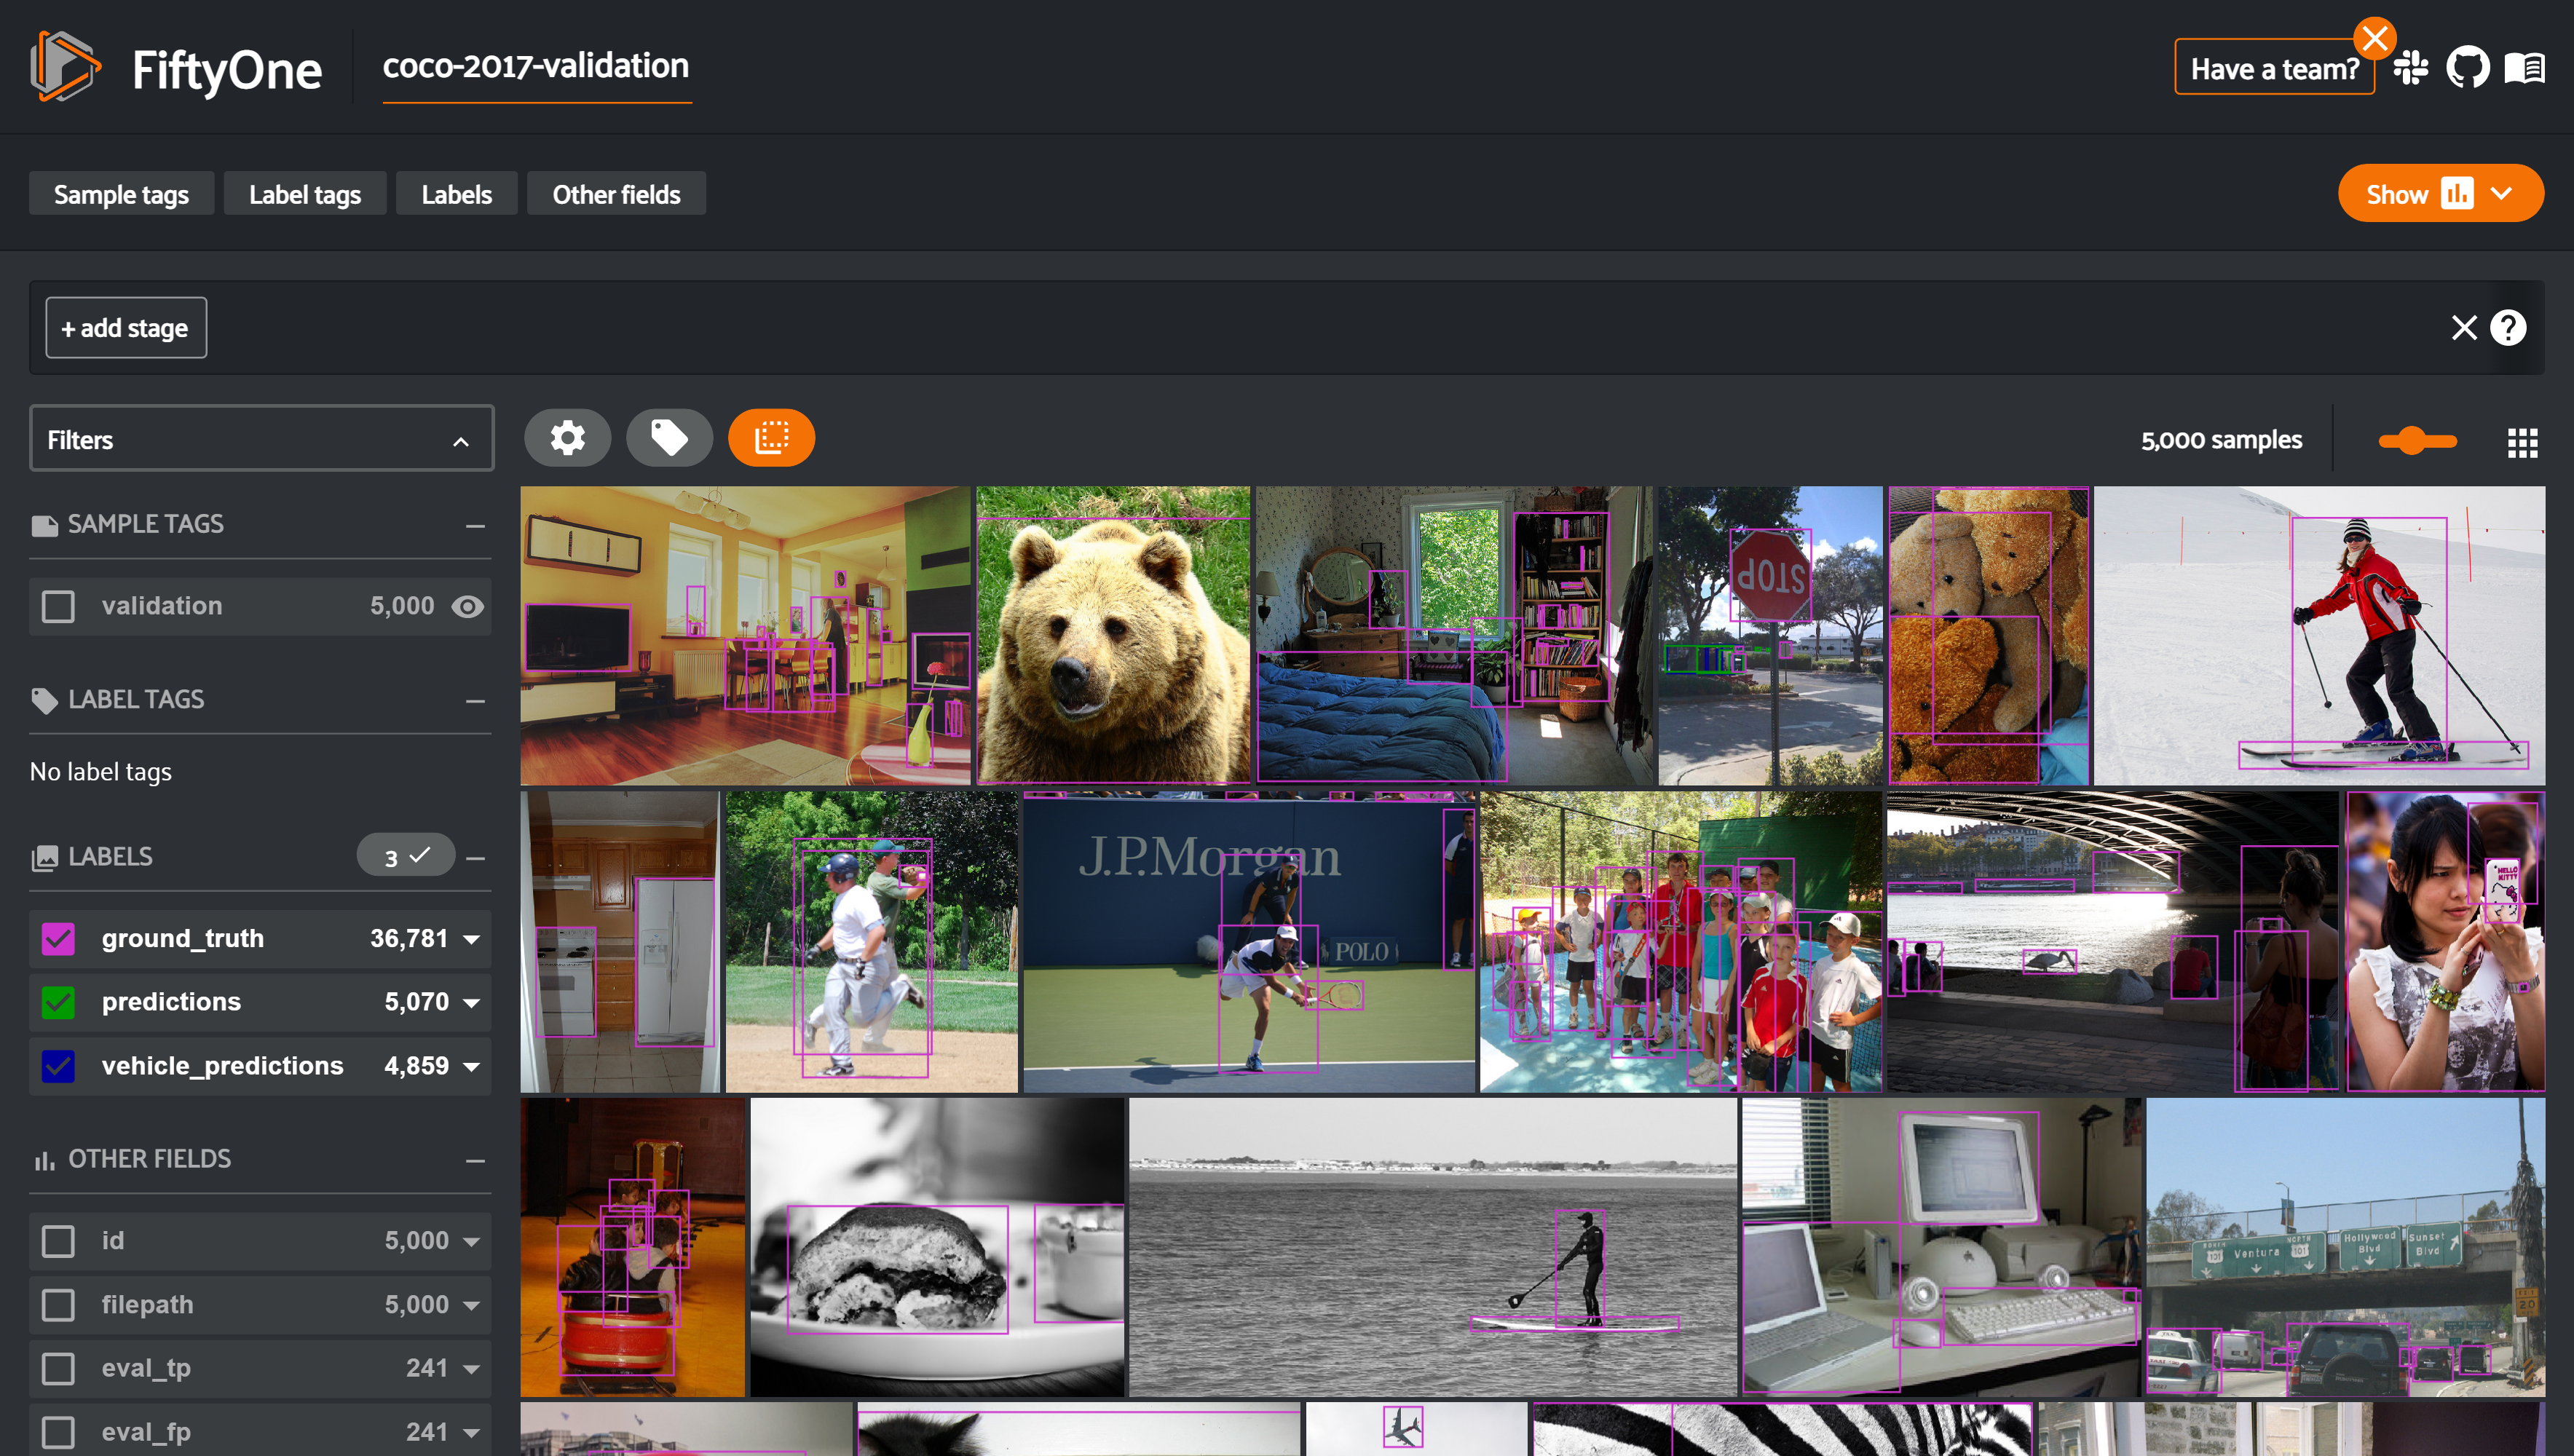

<IPython.core.display.Javascript object>

In [36]:
session = fo.launch_app(fo_dataset)

In [37]:
session.view = test_map_view.sort_by("eval_tp", reverse=False)